# Tutorial 4: clustering

Authors: Léonard Seydoux and René Steinmann

Date: January 16, 2023

This tutorial on reducing the dimension of the scattering coefficients using an independant component analysis. In this Jupyter notebook, we will walk through the process of extracting the most relevant features in order to use them later for clustering. We here follow again the indications in Steinmann et al. ([2021](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2021JB022455)) but we advise that many other methods for reducing the dimensions may be relevant for other datasets. 

In [1]:
import numpy as np
import os
import pickle

from sklearn.decomposition import FastICA
from matplotlib import dates as mdates
from matplotlib import pyplot as plt
from scipy.stats import median_abs_deviation as mad
from scipy.signal import medfilt

## Paths

Please, ensure that you have read and write permission in the following path. Also make sure that the path is located outside the repository, or that is is correctly ignored in the `.gitignore` file, to prevent from pushing it or erasing it when pulling from the main branch.

In [2]:
SAVE_PATH = "example/"

## Load scattering coefficients

First, we load the scattering coefficients and reshape them for any [dimensionality reduction](https://scikit-learn.org/stable/modules/unsupervised_reduction.html) model (here `FastICA`) of the `scikit-learn` package. The shape of the scattering coefficients are given by the following tuples:

- Order 1: `(n_times, n_channel, octaves[0] * resolution[0])`
- Order 2: `(n_times, n_channel, octaves[0] * octaves[1] * resolution[0]  * resolution[1])`
- Order n: `(n_times, n_channel, np.prod(octaves) * np.prod(resolution))`

We then need to collect the all-order scattering coefficients into a two-dimensional matrix for use with `scikit-learn`. 

> Note that the optimal way to load the scattering coefficients is to use `xarray` 

In [3]:
# load data from file
filepath = os.path.join(SAVE_PATH, "scattering_coefficients.npz")
with np.load(filepath) as data:
    order_1 = data["order_1"]
    order_2 = data["order_2"]
    times = data["times"]

# reshape and stack scattering coefficients of all orders
order_1 = order_1.reshape(order_1.shape[0], -1)
order_2 = order_2.reshape(order_2.shape[0], -1)
scattering_coefficients = np.hstack((order_1, order_2))

# transform into log
scattering_coefficients = np.log(scattering_coefficients)

# print info about shape
n_times, n_coeff = scattering_coefficients.shape
print("Collected {} samples of {} dimensions each.".format(n_times, n_coeff))

Collected 719 samples of 216 dimensions each.


## Dimensionality reduction: extract the most relevant features

After loading and stacking the scattering coefficients into a matrix, we can now apply a dimentionality reduction algorithm. We here use the `FastICA` algorithm, but highly recommend to try other algorithms that will allow to proceed in the most adapted way to the data at hand. 

The `FastICA` algorithm looks for a matrix factorization with independant sources, and a mixing matrix. We need to inform the model about how many components (or features) we want to extract in the `n_components` keyword argument  below. The residual shape of the `features` matrix will be `(n_times, n_components)` instead of the initial scattering coefficients shape shown above.

In [4]:
model = FastICA(n_components=10, whiten="unit-variance")
features = model.fit_transform(scattering_coefficients)

## Save the output

We here save the extracted features scattering coefficients as a npz-file, like the scattering coefficients in the previous notebook.

In [5]:
# save the features
filepath = os.path.join(SAVE_PATH, "independant_components.npz")
np.savez(
    filepath,
    features=features,
    times=times,
)

# save the model for later use
filepath = os.path.join(SAVE_PATH, "dimensionality_reductor.pickle")
with open(filepath, "wb") as pickle_file:
    pickle.dump(model, pickle_file, protocol=pickle.HIGHEST_PROTOCOL)

## Have a look at the features

This is a crucial step: do you see structure in the independant components, or do they seem all random? Do the structures correlate with the a priori information at your disposal or to identifiable signal structures? At this stage, it is important to carefully address those questions. The optimal solution may not be to use the `FastICA` model depending on the data at hand, although it can be adapated to many datasets. Playing with the number of components can also be an immportant way of creating structure in the output.

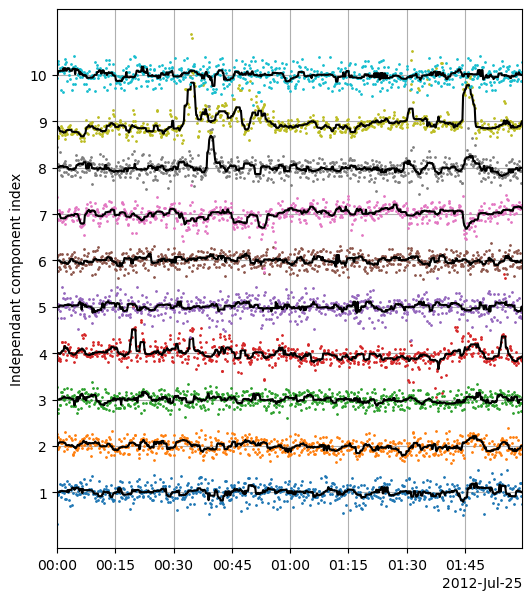

In [6]:
MAD_FACTOR = 10
MEDFILT_KERNEL_SIZE = 11

# Normalize features for display
features_normalized = features / (mad(features, axis=0) * MAD_FACTOR)

# Figure instance
fig, ax = plt.subplots(1, figsize=(6, 7))

# Plot each feature
for index, feature in enumerate(features_normalized.T):
    feature_filtered = medfilt(feature, MEDFILT_KERNEL_SIZE)
    ax.plot(times, feature + index + 1, ".", ms=2)
    ax.plot(times, feature_filtered + index + 1, c="k")

# Labels
ax.grid()
ax.set_yticks(np.arange(features.shape[1]) + 1)
ax.set_ylabel("Independant component index")

# Date labels
dateticks = mdates.AutoDateLocator()
datelabels = mdates.ConciseDateFormatter(dateticks)
ax.xaxis.set_major_locator(dateticks)
ax.xaxis.set_major_formatter(datelabels)
ax.set_xlim(times.min(), times.max())

plt.show()